# **MNIST Multilayer-Perceptron (MLP)**

In this notebook we want to give you an intuition about how to approach a computer vision problem with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. First, we want you to explore the dataset and identify common pitfalls that can occur when working on computer vision tasks. Afterwards, you implement your first neural network, a multilayer perceptron, and train it to be a classifier for the MNIST dataset. Finally, you evaluate your model and take a look on the samples that were misclassified.

<br>

**Task:**

- Please solve all the tasks with code.
- You are free to use any python package you like, however, the imports should be enough to solve all the tasks.
- Questions (marked with QUESTION tag) requires you to write a short and concise text.

**Note:**
- Keep in mind that there is not only one solution for each task.
- If you need any help use the [Tensorflow Documentation](https://www.tensorflow.org/) or the [Keras Documentation](https://keras.io)

## Prerequisites

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2022-10-10 16:37:15.847738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0
[]


In [2]:
# Import MNIST data

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Getting an intuition about the MNIST data and make it ready for the learning task


Have a look at the dataset (train/test) and find out ...
- ... how many samples there are
- ... what shape and dtype the images/labels have
- ... what (unique) labels there are

Can you spot an issue with the data? You will deal with it later on.

In [3]:
pd.DataFrame(
    [
        [len(x_train), x_train.shape, x_train.dtype, y_train.dtype, np.unique(y_train)],
        [len(x_test), x_test.shape, x_test.dtype, y_test.dtype, np.unique(y_test)],
    ],
    columns=["# Samples", "Shape", "dtype image", "dtype label", "unique labels"],
    index=["train", "test"]
)

# The issue might be that numbers written together might not be recognized because they are not separated.


,# Samples,Shape,dtype image,dtype label,unique labels
train,60000,"(60000, 28, 28)",uint8,uint8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
test,10000,"(10000, 28, 28)",uint8,uint8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


Plot the first 25 images of the training set!

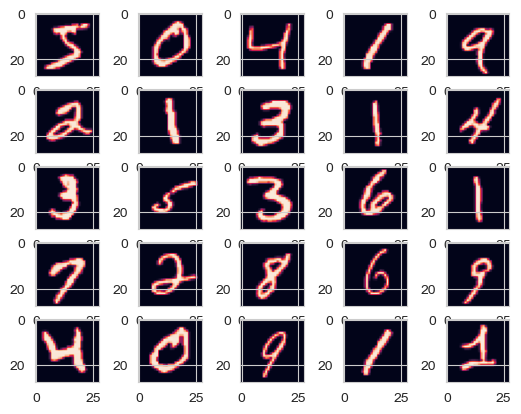

In [4]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])

Verify that the training set is balanced!


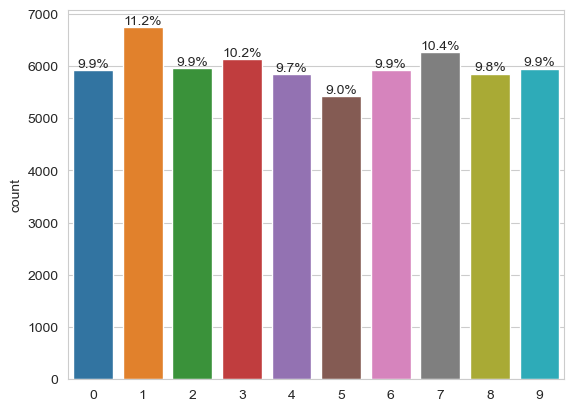

In [5]:
ax = sns.countplot(x=y_train)
_ = ax.bar_label(
    ax.containers[0],
    labels=[f"{label}%" for label in np.round(np.unique(y_train, return_counts=True)[1] * 100 / len(y_train), 1)],

)
# The set is sufficiently balanced


QUESTION: Why is it important to have a balanced training set?  
***So that the model won't be biased towards a certain answer. If a certain number is predominant the model will tend to predict this number more frequent.***


QUESTION: How can imbalanced datasets be tackled in computer vision tasks?  
- ***By removing samples to rebalance the dataset (under-sampling)***
- ***By adding samples or cloning rare samples (over-sampling)***

Prepare the MNIST dataset to properly learn a classifier! Preprocess the images and labels

<br>

QUESTION: Why is it beneficial to convert the categorical labels to one-hot vectors?  
***Most ML models can only take numbers as input. The model will see a relation between two numerical values, which might not be intended.***

QUESTION: Why is it beneficial to normalize the input images?  
***Many models are not resistant against scaling, so non-normalized input leads to distortion of the results.***

<br>

Hint: If you are interested compare the model training with and without normalizing the input images.

In [6]:
# Normalize and flatten the images
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

mms = MinMaxScaler()

print(x_train.min(), x_train.max())
x_train = np.reshape([mms.fit_transform(sample) for sample in x_train], x_train.shape)
print(x_train.min(), x_train.max())
x_test = np.reshape([mms.transform(sample) for sample in x_test], x_test.shape)


0 255
0.0 1.0


In [7]:
# One-hot encode the labels
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
print(y_train)
y_test = ohe.transform(y_test.reshape(-1, 1))


[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


## Learning a mlp


Define an arbitrary mlp!

In [8]:
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1), name="InputLayer"),
    tf.keras.layers.Dense(units=(28 * 28) * 2, activation="sigmoid", name="HiddenLayer1"),
    tf.keras.layers.Dense(units=np.ceil(np.sqrt(28*28*2)), activation="sigmoid", name="HiddenLayer2"),
    tf.keras.layers.Flatten(name="FlattenLayer"),
    tf.keras.layers.Dense(units=10, activation="softmax", name="OutputLayer")
])

mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 28, 28, 1568)      3136      
                                                                 
 HiddenLayer2 (Dense)        (None, 28, 28, 40)        62760     
                                                                 
 FlattenLayer (Flatten)      (None, 31360)             0         
                                                                 
 OutputLayer (Dense)         (None, 10)                313610    
                                                                 
Total params: 379,506
Trainable params: 379,506
Non-trainable params: 0
_________________________________________________________________


2022-10-10 16:37:34.796623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Define hyperparameters, cost function (loss) and optimizer!

In [9]:
batch_sizes: list[int] = [1000, 500, 200, 100]
epochs: list[int] = [2, 5, 10, 20]
losses: list[tf.keras.losses.Loss] = [tf.keras.losses.LogCosh(), tf.keras.losses.CategoricalCrossentropy()]
optimizers: list[tf.keras.optimizers.Optimizer] = [tf.keras.optimizers.Adam(), tf.keras.optimizers.SGD()]
metrics: list[tf.keras.metrics.Metric] = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Accuracy(), tf.keras.metrics.CategoricalCrossentropy()]

from itertools import product

combinations = product(*[optimizers, losses, metrics, batch_sizes, epochs])


Compile the model and train it on the training set!

In [ ]:
for combination in combinations:
    print(f"With:\nOptimizer: {combination[0]},\nLoss: {combination[1]},\nMetric: {combination[2]},\nBatch Size: {combination[3]},\nEpoch: {combination[4]}")
    mlp.compile(optimizer=combination[0], loss=combination[1], metrics=combination[2])
    mlp.fit(x=x_train, y=y_train, batch_size=combination[3], epochs=combination[4], validation_split=0.2)
    print(mlp.evaluate(x=x_test, y=y_test))

With:
Optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fc91ca6f670>,
Loss: <keras.losses.LogCosh object at 0x7fc91ca6f610>,
Metric: CategoricalAccuracy(name=categorical_accuracy,dtype=float32),
Batch Size: 1000,
Epoch: 2
Epoch 1/2


Evaluate the performance of your classifier! It should achieve high accuracy (> 95%) on the test set!

You might adjust the model architecture and/or the hyperparameters if you don't make it above 95% accuracy.

Plot the first 25 misclassified test images and contrast its predicted values with the true labels!

Can you spot some images where even humans have to guess?

Which digit is the most difficult for your model to predict?

In [ ]:
# Make predictions


# Convert predictions and test labels back to categorical


# Find all misclassified test images




In [ ]:
# Plot/Print the findings




In [ ]:
# Count the misclassified images


